# I. Import Library

In [29]:
!pip install tensorflow-addons

In [30]:
!pip install -U tensorflow==2.11.0

In [31]:
# Required installations
!pip install Sastrawi
!pip install datasets
!pip install transformers
!pip install kagglehub

In [32]:
# Core Libraries
import numpy as np
import pandas as pd
import json
import pickle
import re
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Text Processing
import nltk
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
nltk.download('punkt')
nltk.download('stopwords')

# Scikit-Learn for Preprocessing and Metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, cohen_kappa_score

# TensorFlow and Keras for Deep Learning
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Layer
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

# TensorFlow Addons for Advanced Optimization
from tensorflow_addons.optimizers import AdamW

# Hugging Face Transformers for Pretrained Models
from transformers import AutoTokenizer, TFAutoModel, TFBertModel

# Google Colab Utilities
from google.colab import files

# Kaggle Integration
import kagglehub


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# II. Data Loading

In [33]:
# Load the dataset
path = kagglehub.dataset_download("dannytheodore/brimo-app-review")
dataset_path = f"{path}/brimo_googleplaystore_review.csv"
df = pd.read_csv(dataset_path, index_col=0)

100%|██████████| 0.98M/0.98M [00:00<00:00, 1.07MB/s]

Extracting files...


Loading the dataset from Kaggle using the `kagglehub` API.

# III. Exploratory Data Analysis (EDA)

In [34]:
def word_frequency_table(df, column_name, top_n=10):
    # Flatten the text in the column and split into words
    words = ' '.join(df[column_name].dropna()).lower().split()

    # Count the frequency of each word
    word_counts = Counter(words)

    # Create a DataFrame from the word counts
    word_table = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency'])

    # Sort the DataFrame by frequency in descending order
    word_table = word_table.sort_values(by='Frequency', ascending=False).reset_index(drop=True)

    # Return the top N words (default is 10)
    return word_table.head(top_n)

This function counts the frequency of words in the `content` column of a dataset, identifying the most common words. It processes the text by flattening it, converting it to lowercase, and splitting it into words. These words are then counted, and a table of the most frequent ones is created, sorted in descending order. The function helps highlight popular terms that appear often in comments, which can be useful for understanding common topics or sentiments. <br>

Based on **Zipf's Law**, which states that a few words are very common, and most words are rare, this function helps show the words that appear most frequently in the comments. **Luhn’s Hypothesis** suggests that significant words (those that add meaning) are less frequent than common ones but should still be noticed. By focusing on the most frequent meaningful words, this function can help improve text analysis, such as sentiment analysis, by identifying key terms and reducing noise from common but unimportant words. <br>

<img src="https://mungingdata.wordpress.com/wp-content/uploads/2017/11/zipfs-and-luhn.png" alt="Zipf's Law and Luhn's Algorithm" width="400" height="300">


In [35]:
word_frequency_table(df, 'content', top_n=100)

,Word,Frequency
0,sangat,3774
1,bagus,2811
2,dan,2101
3,membantu,2032
4,di,1900
...,...,...
95,terima,193
96,registrasi,191
97,pas,190
98,coba,186


Applying the function and see the top 100 words used. After that select the words that mostly don't carry significant meaning and add that to the stopwords that will be removed from each comment.

# IV. Feature Engineering (FE)

In [36]:
# Text preprocessing function
def preprocess_text(text, stop_words, stemmer):
    try:
        text = text.lower()
        text = re.sub("@[A-Za-z0-9_]+", " ", text)  # Remove mentions
        text = re.sub("#[A-Za-z0-9_]+", " ", text)  # Remove hashtags
        text = re.sub(r"\\n", " ", text)  # Remove newlines
        text = re.sub(r"http\S+", " ", text)  # Remove URLs
        text = re.sub(r"www.\S+", " ", text)  # Remove www URLs
        text = re.sub("[^A-Za-z\s']", " ", text)  # Remove non-letter characters
        tokens = text.split()
        tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
        tokens = [stemmer.stem(word) for word in tokens]  # Apply stemming
        return ' '.join(tokens)
    except Exception as e:
        print(f"Error processing text: {text}\n{e}")
        return text

Create a function to preprocess the data, such as making it lowercase, removing the hashtag, splitting it into tokens, and stemming it to simplify the token.

In [37]:
# Load IndoBERT Tokenizer and Model
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
base_model = TFAutoModel.from_pretrained("indobenchmark/indobert-base-p1")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/656M [00:00<?, ?B/s]

Some layers from the model checkpoint at indobenchmark/indobert-base-p1 were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at indobenchmark/indobert-base-p1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


`AutoTokenizer` loads the **IndoBERT-base-p1** model and its corresponding tokenizer from the **Hugging Face** model hub. The tokenizer converts raw text into token IDs and attention masks suitable for the model, while the `TFAutoModel` loads the pretrained IndoBERT model as a TensorFlow object, which then will be use for sentiment analysis on Indonesian text.

In [38]:
# Custom Keras Layer to wrap the TFAutoModel
class BertLayer(Layer):
    def __init__(self, base_model, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.base_model = base_model

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state

    def get_config(self):
        config = super(BertLayer, self).get_config()
        config.update({"base_model": self.base_model})
        return config

Create a custom Keras layer called `BertLayer` to wrap the **TFAutoModel** (IndoBERT). In the `__init__` method, initialize the layer with the base model and pass any additional arguments. In the `call` method, define how the layer processes inputs: it takes `input_ids` and `attention_mask`, then passes them to the base model, returning the last hidden state. Finally, in the `get_config` method, include the `base_model` configuration so that it can be properly saved and restored.

In [39]:
# Add Pooler Layer (from the first [CLS] token)
class PoolerLayer(Layer):
    def __init__(self, **kwargs):
        super(PoolerLayer, self).__init__(**kwargs)

    def call(self, inputs):
        cls_token = inputs[:, 0, :]  # First token's output (the [CLS] token)
        pooled_output = tf.keras.activations.tanh(cls_token)  # Apply tanh activation
        return pooled_output

Create a custom Keras layer called `PoolerLayer` to extract the output from the first token (`[CLS]` token) for sentiment analysis. In the `call` method, select the first token's output from the model’s hidden states, then apply the **tanh** activation function to it. The resulting pooled output is returned, which can be used to classify the sentiment of the input text.

In [40]:
# Map the labels to positive, neutral, negative
def map_labels(score):
    if score >= 4:
        return 2  # Positive
    elif score == 3:
        return 1  # Neutral
    else:
        return 0  # Negative

Create a function called `map_labels` to map the review scores to sentiment labels: **positive**, **neutral**, and **negative**. The function takes the score as input and returns a corresponding label: a score of 4 or above is mapped to 2 (positive), a score of 3 is mapped to 1 (neutral), and scores below 3 are mapped to 0 (negative). This reduces the number of classes from a range of scores (e.g., 1-5) into three distinct sentiment categories, simplifying the task for sentiment analysis.

In [41]:
df['label'] = df['score'].apply(map_labels)

Apply the `map_labels` function to `score` column then create new column named `label`.

In [42]:
# Clean the text data
manual_stopwords = ["di", "ke", "dari", "yang", "dan", "atau", "dengan", "untuk", "ini", "itu", "aja", "saja", "lah", "bri", "brimo", "aplikasi", "rekening", "coba", "yg", "ke", "untuk", "nya", "saya", "dia", "dan", "sangat", "video", "login", "apk", "jadi", "akun", "malah", "uang", "banget", "dalam", "atm", "padahal"]
stop_words = set(stopwords.words('indonesian'))
stop_words.update(manual_stopwords)
factory = StemmerFactory()
stemmer = factory.create_stemmer()
cleaned_texts = [preprocess_text(text, stop_words, stemmer) for text in df['content'].tolist()]

Create a process to clean the text data by defining a set of **manual stopwords** specific to the dataset, such as common words and terms related to the application (e.g., "di", "ke", "bri", "brimo"). The NLTK stopwords for the Indonesian language are also loaded and combined with the manual stopwords. </br>

Then, a **StemmerFactory** is used to create a stemmer for Indonesian text, which reduces words to their base forms. The `preprocess_text` function is applied to each review in the dataset, removing stopwords and stemming the remaining words, resulting in a list of cleaned texts ready for further analysis or modeling.

In [43]:
# One-Hot Encoding for Labels
labels = df['label'].tolist()
encoder = OneHotEncoder(sparse_output=False)
labels_one_hot = encoder.fit_transform(np.array(labels).reshape(-1, 1))

Create a process for **One-Hot Encoding** the labels by first extracting the labels from the dataset. The `OneHotEncoder` from scikit-learn is then used to transform the labels into a one-hot encoded format, where each label is represented as a binary vector. The encoded labels are stored in `labels_one_hot`, which can be used as input for model training, enabling the model to learn distinct classes for each label.

In [44]:
# Split the data into training, validation, and test sets (80% train, 10% validation, 10% test)
train_texts, temp_texts, train_labels, temp_labels = train_test_split(cleaned_texts, labels_one_hot, test_size=0.2, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=42)

Create a process to **split the data** into training, validation, and test sets. First, the cleaned texts and one-hot encoded labels are split into training (80%) and temporary sets (20%). Then, the temporary set is further divided into validation and test sets, each containing 10% of the original data. This ensures that the model can be trained on a large portion of the data, while also having separate validation and test sets for model evaluation and tuning.

In [45]:
# Tokenize the training, validation, and test texts
def tokenize_texts(texts, tokenizer, max_length=128):
    return tokenizer(texts, padding='max_length', truncation=True, max_length=max_length, return_tensors='tf')

Tokenize the training, validation, and test texts using the provided tokenizer. The `tokenize_texts` function takes the texts and converts them into tokenized inputs suitable for the model. It ensures that each text is padded or truncated to a fixed length (default 128), returning the results as TensorFlow-compatible tensors for easy integration into the model.

In [46]:
train_tokenized_inputs = tokenize_texts(train_texts, tokenizer)
val_tokenized_inputs = tokenize_texts(val_texts, tokenizer)
test_tokenized_inputs = tokenize_texts(test_texts, tokenizer)

train_input_ids = train_tokenized_inputs['input_ids']
train_attention_masks = train_tokenized_inputs['attention_mask']
val_input_ids = val_tokenized_inputs['input_ids']
val_attention_masks = val_tokenized_inputs['attention_mask']
test_input_ids = test_tokenized_inputs['input_ids']
test_attention_masks = test_tokenized_inputs['attention_mask']

Tokenize the training, validation, and test texts and extract the relevant components for model input. The `train_tokenized_inputs`, `val_tokenized_inputs`, and `test_tokenized_inputs` store the tokenized versions of the respective datasets. From these, the `input_ids` and `attention_mask` are extracted for each dataset, which are essential for the model to process the tokenized texts and handle padding properly during training and evaluation.

In [47]:
# Compute class weights for the model
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

Compute class weights to address class imbalance in the dataset. The `compute_class_weight` function calculates the weights for each class based on their frequency, ensuring that the model gives more attention to underrepresented classes during training. The `class_weights_dict` maps each class label to its corresponding weight, which can be used in the model training process to balance the contribution of each class and improve overall model performance.

In [48]:
# Convert datasets to TensorFlow datasets
train_data_tf = tf.data.Dataset.from_tensor_slices(({
    'input_ids': train_input_ids,
    'attention_mask': train_attention_masks
}, train_labels)).batch(32).shuffle(1000)

val_data_tf = tf.data.Dataset.from_tensor_slices(({
    'input_ids': val_input_ids,
    'attention_mask': val_attention_masks
}, val_labels)).batch(32)

test_data_tf = tf.data.Dataset.from_tensor_slices(({
    'input_ids': test_input_ids,
    'attention_mask': test_attention_masks
}, test_labels)).batch(32)

Convert the datasets into TensorFlow datasets for efficient processing during training, validation, and testing. The `train_data_tf`, `val_data_tf`, and `test_data_tf` are created by wrapping the tokenized inputs and labels into TensorFlow `Dataset` objects. These datasets are batched (with a batch size of 32) and shuffled for the training set to improve training efficiency and reduce overfitting. The validation and test datasets are also batched, but not shuffled, as they are used for evaluation.

# V. Model Definition

In [ ]:
# Define the model architecture
input_ids = Input(shape=(128,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(128,), dtype=tf.int32, name='attention_mask')

Define two input layers for the model: one for `input_ids` representing the tokenized text and another for `attention_mask` to specify which tokens should be attended to. Both inputs are set to a shape of (128,) to align with the tokenized text length.

In [ ]:
# Use the custom BertLayer
embeddings = BertLayer(base_model)([input_ids, attention_mask])

Utilize the custom `BertLayer` to process the `input_ids` and `attention_mask` inputs, generating embeddings from the `base_model`. These embeddings represent the contextualized features of the input text.

In [ ]:
# Add Pooler Layer to get the [CLS] token output
pooled_output = PoolerLayer()(embeddings)

Apply the `PoolerLayer` to extract the output of the `[CLS]` token, which serves as a summary representation of the entire input text. This pooled output is used for downstream tasks like sentiment classification.

In [ ]:
# Add a dropout layer for regularization
dropout = Dropout(0.4)(pooled_output)

Introduce a `Dropout` layer with a rate of 0.4 to prevent overfitting by randomly setting **40%** of the units to zero during training. This helps improve the model's generalization ability.

In [ ]:
# Add a dense layer with L2 regularization
classifier = Dense(3, activation='softmax', kernel_regularizer=l2(0.01))(dropout)

Add a Dense layer with 3 units and a softmax activation function for multi-class classification. L2 regularization is applied to the layer's weights with a strength of 0.01 to prevent overfitting by penalizing large weight values.

In [ ]:
# Define the complete model
model = Model(inputs=[input_ids, attention_mask], outputs=classifier)

Define the model by specifying the inputs as `input_ids` and `attention_mask`, and the output as the classifier layer. This combines all the components into a complete architecture ready for training.

In [ ]:
# Freeze BERT layers
for layer in base_model.layers:
    layer.trainable = False  # Freeze BERT model layers

# Make the classifier layer trainable
for layer in model.layers:
    if isinstance(layer, Dense):  # Or any other specific layer type you want to fine-tune
        layer.trainable = True


Freeze the layers of the **BERT** model to retain its pre-trained weights while making the classifier layer trainable for fine-tuning. This allows the classifier to adapt to the specific task without altering the BERT layers.

In [18]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name="tp", initializer="zeros")
        self.false_positives = self.add_weight(name="fp", initializer="zeros")
        self.false_negatives = self.add_weight(name="fn", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert probabilities to predicted class indices
        y_pred = tf.argmax(y_pred, axis=-1)
        y_true = tf.argmax(y_true, axis=-1)

        # Calculate true positives, false positives, and false negatives
        tp = tf.reduce_sum(tf.cast((y_true == y_pred) & (y_true != 0), tf.float32))
        fp = tf.reduce_sum(tf.cast((y_true != y_pred) & (y_pred != 0), tf.float32))
        fn = tf.reduce_sum(tf.cast((y_true != y_pred) & (y_true != 0), tf.float32))

        # Update state variables
        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):
        precision = self.true_positives / (
            self.true_positives + self.false_positives + K.epsilon()
        )
        recall = self.true_positives / (
            self.true_positives + self.false_negatives + K.epsilon()
        )
        f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
        return f1

    def reset_state(self):
        # Reset all state variables
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)


Create a custom `F1Score` class to compute the F1 score as a metric during model training. It tracks true positives, false positives, and false negatives, then calculates precision, recall, and the F1 score. The state is updated at each step, and the result is calculated by applying the F1 score formula.

In [ ]:
# Compile the model with AdamW optimizer and Recall metric
optimizer = AdamW(learning_rate=2e-5, weight_decay=1e-5)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=[F1Score()]  # Add custom F1Score metric
)

Compile the model using the AdamW optimizer with a learning rate of 2e-5 and weight decay of 1e-5. The model is configured with categorical cross-entropy loss and the custom `F1Score` metric to evaluate performance during training.

# VI. Model Training

In [ ]:
# Model Checkpoint callback to save the best model during training
checkpoint_callback = ModelCheckpoint("best_model.h5",
                                      save_best_only=True,
                                      monitor='val_loss',
                                      mode='min',
                                      verbose=1)

Set up a **ModelCheckpoint** callback to save the best model during training. The model will be saved with the filename `best_model.h5` whenever the validation loss improves, ensuring that only the best-performing model is stored.

In [ ]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

Define an **EarlyStopping** callback to halt training if there is no improvement in the monitored metric (validation loss) for 3 consecutive epochs. This callback ensures that the model returns to its best state by restoring the weights from the epoch with the best performance.

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2)

Set up a **ReduceLROnPlateau** callback to decrease the learning rate by a factor of 0.1 if the validation loss doesn't improve for 2 consecutive epochs. This helps in fine-tuning the learning process when the model plateaus, allowing for more gradual updates.

In [ ]:
# Train the model with early stopping
history = model.fit(
    train_data_tf,
    validation_data=val_data_tf,
    epochs=35,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, reduce_lr, checkpoint_callback]
)

Epoch 1/35
431/431 [==============================] - ETA: 0s - loss: 1.2008 - f1_score: 0.4761
Epoch 1: val_loss improved from inf to 0.82849, saving model to best_model.h5
431/431 [==============================] - 1702s 4s/step - loss: 1.2008 - f1_score: 0.4761 - val_loss: 0.8285 - val_f1_score: 0.8193 - lr: 2.0000e-05
Epoch 2/35
431/431 [==============================] - ETA: 0s - loss: 1.1250 - f1_score: 0.6474
Epoch 2: val_loss improved from 0.82849 to 0.75821, saving model to best_model.h5
431/431 [==============================] - 1696s 4s/step - loss: 1.1250 - f1_score: 0.6474 - val_loss: 0.7582 - val_f1_score: 0.8154 - lr: 2.0000e-05
Epoch 3/35
431/431 [==============================] - ETA: 0s - loss: 1.0852 - f1_score: 0.6873
Epoch 3: val_loss improved from 0.75821 to 0.72459, saving model to best_model.h5
431/431 [==============================] - 1700s 4s/step - loss: 1.0852 - f1_score: 0.6873 - val_loss: 0.7246 - val_f1_score: 0.8202 - lr: 2.0000e-05
Epoch 4/35
431/431 [

Trains the model using the training data and validates it with separate validation data. The training process includes the following features: <br>

* **Class Weights**: Helps the model pay more attention to underrepresented classes.
* **Early Stopping**: Stops training if the validation loss doesn’t improve for a few epochs, preventing overfitting.
* **Reduce Learning Rate**: Lowers the learning rate if the validation loss stops improving, helping the model learn more effectively.
* **Save Best Model**: Saves the model's best weights after each epoch

After no improvement in validation loss during epochs 21 and 22, the Early Stopping callback was triggered. This helps in preventing overfitting by halting training early and restoring the model to the best weights, achieved at epoch 20 when the validation loss was at its lowest (0.56845). <br>

With the key metrics:

* **Training Loss**: Started at 1.2008 and gradually decreased to 0.5589 by epoch 20.
* **Validation Loss**: Started at 0.8285 and reached its minimum of 0.56845 at epoch 20.
* **Training F1 Score**: Started at 0.8193 and peaked at 0.8566 at epoch 20.
* **Validation F1 Score**: Improved from 0.8193 to 0.8566 by epoch 20.

# VII. Model Saving

## A. Last Model

In [ ]:
# Save the model and tokenizer
model.save('last_model.h5')

## B. Tokenizer

In [ ]:
tokenizer.save_pretrained('tokenizer')

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/vocab.txt',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

## C. Training History

In [ ]:
# Save the training history
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)


## D. Class Weights

In [2]:
# Save the class weights
np.save('class_weights.npy', class_weights_dict)

NameError: name 'np' is not defined

## E. Last Model Configuration

In [ ]:
# Save the model configuration
with open('model_config.json', 'w') as f:
    json.dump(model.get_config(), f)

## F. Download to local machine

In [ ]:
files.download('/content/best_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('/content/last_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!zip -r /content/tokenizer_folder.zip /content/tokenizer

files.download('/content/tokenizer_folder.zip')

  adding: content/tokenizer/ (stored 0%)
  adding: content/tokenizer/tokenizer.json (deflated 71%)
  adding: content/tokenizer/tokenizer_config.json (deflated 74%)
  adding: content/tokenizer/special_tokens_map.json (deflated 42%)
  adding: content/tokenizer/vocab.txt (deflated 53%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Download all files to your local machine
files.download('training_history.pkl')
files.download('class_weights.npy')
files.download('model_config.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## G. Model Loading

### G.I. Model

In [19]:
# Register TFBertModel, BertLayer, PoolerLayer, and F1Score as custom objects
custom_objects = {
    'TFBertModel': TFBertModel,
    'BertLayer': BertLayer,  # Replace with the actual custom layer class if needed
    'PoolerLayer': PoolerLayer,  # Replace with the actual custom layer class if needed
    'F1Score': F1Score  # Replace with your custom metric function
}

# Load the model with custom objects
model = load_model('/content/best_model.h5', custom_objects=custom_objects)

In [27]:
# Recreate the AdamW optimizer
optimizer = AdamW(learning_rate=2e-5, weight_decay=1e-5)

# Recompile the model with the AdamW optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[F1Score()])

### G.II. Training History

In [23]:
# Load the training history from the file
with open('/content/training_history.pkl', 'rb') as f:
    history = pickle.load(f)

# VIII. Model Evaluation

## A. Training History Evaluation

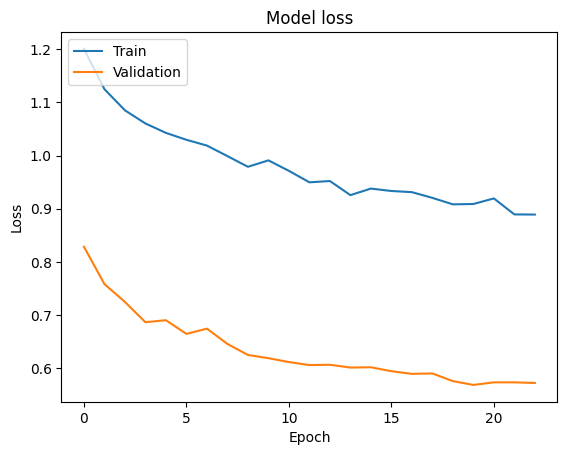

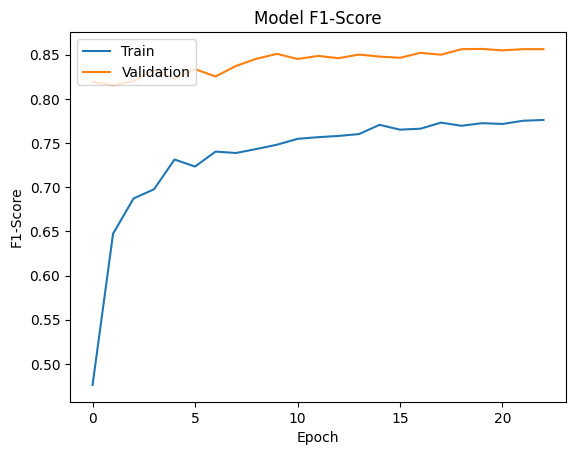

In [26]:
# Plot training & validation loss values
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation recall values
plt.plot(history['f1_score'])
plt.plot(history['val_f1_score'])
plt.title('Model F1-Score')
plt.ylabel('F1-Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


Based on the training output, the model appears to be making good progress, but it may be nearing its performance limit. <br>

Here are key observations:

* **Training Loss and F1-Score**: The loss gradually decreased from 1.2008 at epoch 1 to 0.9090 at epoch 20. The F1 score improved as well, reaching a peak of 0.7726 at epoch 20, which is a good indication of the model's learning capacity.
* **Validation Loss and F1-Score**: The validation loss improved initially, reaching its best value at 0.56845 at epoch 20, and the validation F1 score also improved steadily, reaching a peak of 0.8566 at epoch 20. This suggests the model generalizes well to the validation data.
* **Early Stopping**: Early stopping was triggered, and the best model was selected at epoch 20, as further epochs did not lead to any significant improvement in validation loss or F1 score. <br>

**Insight** <br>
The model is a **good fit**. It exhibits steady improvement in both training and validation performance up until epoch 20. The early stopping indicates that the model has likely reached a point where further training would lead to diminishing returns or overfitting.
Generalization: The model's validation performance (F1 score and loss) is strong, suggesting good generalization to unseen data.

## B. Confusion Matrix

54/54 [==============================] - 133s 2s/step


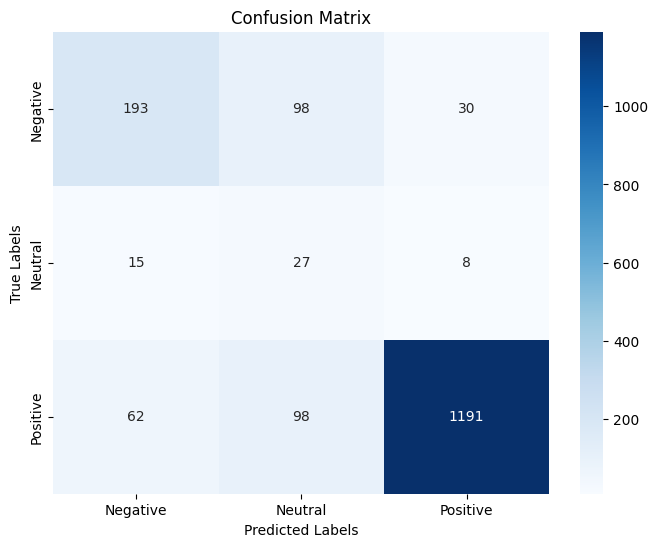

In [72]:
# Step 1: Get model predictions
# Predict on the test data
predictions = model.predict(test_data_tf)

# Step 2: Convert predictions from one-hot encoding to label indices
predicted_labels = np.argmax(predictions, axis=-1)
true_labels = np.argmax(test_labels, axis=-1)

# Step 3: Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Step 4: Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


**Key Metrics**

- **True Positives (TP)**:  
  Correctly predicted positive class: 1191

- **True Negatives (TN)**:  
  Correctly predicted negative class: 193

- **False Positives (FP)**:  
  Incorrectly predicted positive class: 62

- **False Negatives (FN)**:  
  Incorrectly predicted negative class: 30

**Class Metrics**

- **Recall for Positive Class**:  
  $$
  \text{Recall}_{\text{Positive}} = \frac{TP}{TP + FN} = \frac{1191}{1191 + 30} = 0.975
  $$

- **Precision for Positive Class**:  
  $$
  \text{Precision}_{\text{Positive}} = \frac{TP}{TP + FP} = \frac{1191}{1191 + 62} = 0.950
  $$

- **Recall for Negative Class**:  
  $$
  \text{Recall}_{\text{Negative}} = \frac{TN}{TN + FP} = \frac{193}{193 + 62} = 0.757
  $$

- **Precision for Negative Class**:  
  $$
  \text{Precision}_{\text{Negative}} = \frac{TN}{TN + FN} = \frac{193}{193 + 30} = 0.865
  $$

**F1-Score**

- **F1-Score for Positive Class**:  
  $$
  F1_{\text{Positive}} = 2 \times \frac{\text{Precision}_{\text{Positive}} \times \text{Recall}_{\text{Positive}}}{\text{Precision}_{\text{Positive}} + \text{Recall}_{\text{Positive}}} = 2 \times \frac{0.950 \times 0.975}{0.950 + 0.975} = 0.962
  $$

- **F1-Score for Negative Class**:  
  $$
  F1_{\text{Negative}} = 2 \times \frac{\text{Precision}_{\text{Negative}} \times \text{Recall}_{\text{Negative}}}{\text{Precision}_{\text{Negative}} + \text{Recall}_{\text{Negative}}} = 2 \times \frac{0.865 \times 0.757}{0.865 + 0.757} = 0.807
  $$

**Insight** <br>

Based on the confusion matrix and calculated metrics, the model demonstrates excellent performance for predicting the **positive class** with a high recall of 0.975 and precision of 0.950, leading to an F1-score of 0.962. However, the **negative class** shows a lower recall of 0.757 and precision of 0.865, resulting in an F1-score of 0.807. This suggests that while the model is strong in predicting **positive outcomes**, there is room for improvement in handling **negative cases**, which could be addressed through strategies such as rebalancing the data or further optimization of the model. <br>

In the confusion matrix, the **negative class** strictly refers to the **Negative sentiment**. The **Neutral class** is a separate category. The recall and precision metrics for the **negative class** are calculated based on the **Negative** sentiment instances only, and do not include **Neutral** sentiment instances. Thus, the **Negative class** refers solely to **Negative sentiment**, while **Neutral** sentiment is handled independently.

## C. ROC AUC

In [50]:
# Predict probabilities on the test set
test_pred_probs = model.predict(test_data_tf)

# Ensure that probabilities are in the shape (n_samples, n_classes)
# Compute ROC AUC with balanced average for multi-class classification
roc_auc = roc_auc_score(test_labels, test_pred_probs, average='weighted', multi_class='ovr')

print(f"Balanced ROC AUC (Weighted): {roc_auc}")


54/54 [==============================] - 125s 2s/step
Balanced ROC AUC (Weighted): 0.9406855179126441


**Insight:**

The model demonstrates strong performance with a **Balanced ROC AUC (Weighted)** score of **0.9407**. This indicates that the model is highly effective at distinguishing between the different sentiment classes (Negative, Neutral, and Positive), even with class imbalance. A score above 0.9 typically suggests excellent performance in terms of classification ability across all classes, balancing the performance for both major and minor classes.

Given the **balanced** nature of the ROC AUC, it shows that the model is not biased toward any particular class, indicating good generalization and robust classification for all sentiment categories.


## D. Cohen's Kappa Score

In [55]:
# Prepare lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the TensorFlow dataset to collect true labels and predictions
for batch in test_data_tf:
    inputs, labels = batch
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    # Make predictions for the current batch
    batch_pred_probs = model.predict({
        'input_ids': input_ids,
        'attention_mask': attention_mask
    })

    # Convert the predicted probabilities to predicted class labels
    batch_pred_labels = np.argmax(batch_pred_probs, axis=-1)

    # Append true and predicted labels to the lists
    true_labels.extend(np.argmax(labels, axis=-1))  # Assuming the labels are one-hot encoded
    predicted_labels.extend(batch_pred_labels)

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Compute Cohen's Kappa score for multi-class classification
kappa_score = cohen_kappa_score(true_labels, predicted_labels)

print(f"Cohen's Kappa Score: {kappa_score}")


1/1 [==============================] - 5s 5s/step
Cohen's Kappa Score: 0.5563344752026577


The Cohen's Kappa score ranges between -1 and 1, where:

- **1** indicates perfect agreement between the true labels and predicted labels.
- **0** indicates no agreement beyond what would be expected by chance (i.e., random guessing).
- **Negative values** indicate less agreement than would be expected by chance, which usually implies systematic disagreement between the predictions and true labels.

In this case, the score of **0.556** suggests moderate agreement, meaning the model performs better than random chance but still has considerable room for improvement.

# IX. Model Inference

In [60]:
# Function to preprocess and tokenize multiple reviews
def preprocess_and_tokenize_reviews(reviews, tokenizer, stop_words, stemmer, max_length=128):
    # Preprocess each review
    cleaned_reviews = [preprocess_text(review, stop_words, stemmer) for review in reviews]

    # Tokenize the cleaned reviews
    tokenized_reviews = tokenizer(cleaned_reviews, padding='max_length', truncation=True, max_length=max_length, return_tensors='tf')

    return tokenized_reviews

In [71]:
# Example list of multiple reviews
reviews = [
    "Aplikasi Brimo sangat membantu untuk transaksi cepat dan mudah.",
    "Aplikasi ini biasa aja gak ada spesialnya bro dibandingkan mobile app laen.",
    "Layanan sangat parah, aplikasi sering mengalami bug.",
    "Aplikasi ini sangat canggih, saya tunggu seabad baru bisa buka",
    "Setelah memakai aplikasi ini, saya jadi super sabar, bahkan bisa menunggu selama berjam-jam tanpa merasa marah 😏",
    "Layanan Brimo sangat bagus dan user-friendly. Sangat saya rekomendasikan.",
    "Serius, aplikasi Brimo tuh kayak roller coaster, kadang cepet, kadang lambat, tapi kalau udah nyangkut, rasanya kaya hidup lo stuck di traffic Jakarta, udah deh nggak mau pake lagi!",
    "Aplikasi ini seperti pelari tercepat di dunia, cuma sayangnya, dia lari di tempat.",
    "Aplikasi ini adalah pelita yang menyinari gelapnya dunia, sayangnya, pelita itu mati setiap dua menit sekali",
    "Akoehh ras@ aplikasie ini cucok oentoek @nak moedA"
]

# Preprocess and tokenize reviews
tokenized_reviews = preprocess_and_tokenize_reviews(reviews, tokenizer, stop_words, stemmer)

# Get the input_ids and attention_mask
input_ids = tokenized_reviews['input_ids']
attention_masks = tokenized_reviews['attention_mask']

# Predict sentiment for each review
predictions = model.predict({'input_ids': input_ids, 'attention_mask': attention_masks})

# Decode the predictions
predicted_labels = np.argmax(predictions, axis=-1)

# Map the predicted labels back to sentiment
sentiment_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
predicted_sentiments = [sentiment_map[label] for label in predicted_labels]

# Print results
for review, sentiment in zip(reviews, predicted_sentiments):
    print(f"Review: {review}\nPredicted Sentiment: {sentiment}\n")

1/1 [==============================] - 1s 721ms/step
Review: Aplikasi Brimo sangat membantu untuk transaksi cepat dan mudah.
Predicted Sentiment: Positive

Review: Aplikasi ini biasa aja gak ada spesialnya bro dibandingkan mobile app laen.
Predicted Sentiment: Neutral

Review: Layanan sangat parah, aplikasi sering mengalami bug.
Predicted Sentiment: Negative

Review: Aplikasi ini sangat canggih, saya tunggu seabad baru bisa buka
Predicted Sentiment: Negative

Review: Setelah memakai aplikasi ini, saya jadi super sabar, bahkan bisa menunggu selama berjam-jam tanpa merasa marah 😏
Predicted Sentiment: Neutral

Review: Layanan Brimo sangat bagus dan user-friendly. Sangat saya rekomendasikan.
Predicted Sentiment: Positive

Review: Serius, aplikasi Brimo tuh kayak roller coaster, kadang cepet, kadang lambat, tapi kalau udah nyangkut, rasanya kaya hidup lo stuck di traffic Jakarta, udah deh nggak mau pake lagi!
Predicted Sentiment: Negative

Review: Aplikasi ini seperti pelari tercepat di dun

Based on the testing results with inference data, the model performs fairly well in classifying sentiment into positive, negative, or neutral categories. However, challenges arise when handling sarcasm, figures of speech (like metaphors and hyperboles), and informal "alay" language (distorted words in internet slang). Sarcasm, in particular, confuses the model, as it often involves implicit negative sentiment disguised by seemingly positive wording. For example, a phrase like **"This app is like the fastest runner in the world, except it runs in place"** is intended to express frustration, but the model might incorrectly classify it as neutral because it contains positive terms. <br>

Additionally, hyperbolic expressions such as **"Aplikasi ini seperti pelita yang menyinari gelapnya dunia, sayangnya, pelita itu mati setiap dua menit sekali"** (The app is like a light that illuminates the dark world, but sadly, it dies every two minutes) could be misclassified due to the contrast in tone. **"Alay"** language, like **"Akoehh ras@ aplikasie ini cucok oentoek @nak moedA"**, further complicates sentiment classification due to its deviation from standard language patterns. These challenges suggest that while the model is **accurate** for *straightforward sentiments*, it needs more training on diverse and complex linguistic inputs to improve its ability to handle sarcasm and non-standard language.

# X. Conclusion

In conclusion, the model performs well overall, particularly in predicting **positive sentiment** with high *precision* and *recall*. However, its performance on the **negative class** leaves room for improvement. The **Cohen's Kappa score** of *0.556* indicates moderate agreement, suggesting that the model has potential but still requires optimization for better alignment with true labels. Despite its strengths, challenges arise in handling **sarcasm**, **figures of speech**, and **informal language** like `alay`, which often confuse the model and lead to misclassifications. This indicates that while the model is effective for **straightforward sentiment classification**, further training with more **diverse** and **complex linguistic inputs** is necessary to enhance its accuracy in handling nuanced language.


# XI. Further Improvement

To further improve the model, several strategies can be implemented:

1. **Data Handling & Augmentation**
   - **Class Imbalance**: The negative class shows lower performance in terms of recall and precision. Adding more data for the **Negative** and **Neutral** classes can help improve the model's performance. This will support better generalization, especially for these underrepresented classes.
   - **Data Augmentation**: Introducing more variability in the dataset for **Negative** and **Neutral** classes by paraphrasing or augmenting data through synthetic text generation can be useful. This will be especially helpful in handling challenging cases such as sarcasm, figurative language, or non-standard expressions.

2. **Model Improvements**
   - **Hyperparameter Tuning**: Experimenting with different hyperparameters like learning rate, batch size, and optimizer type (e.g., SGD) can help enhance the model's performance.
   - **Ensemble Learning**: Combining multiple models (e.g., IndoBERT with an LSTM or CNN) can improve generalization and robustness, which can be beneficial in handling edge cases like sarcasm or ambiguous language.

3. **Handling Sarcasm and Figurative Language**
   - **Sarcasm Detection**: Since sarcasm confuses the model, incorporating sarcasm-specific features or a separate classifier trained to identify sarcastic statements can help improve performance. Sarcasm detection can aid in correctly classifying seemingly positive but contextually negative statements.
   - **Figurative Language**: Training the model on datasets containing **hyperboles**, **metaphors**, and other figures of speech will improve understanding of non-literal language. Alternatively, creating a specialized model or additional feature set to detect and interpret these types of expressions may be helpful.

4. **Handling Informal Language (e.g., Alay Language)**
   - **Text Preprocessing**: Implementing more sophisticated text preprocessing steps to handle informal and slang language (e.g., "alay" language) can be beneficial. Normalization techniques to convert distorted words into their more formal counterparts, using a dictionary of common slang, or specific rules could improve performance.
   - **Custom Tokenizer**: Using a custom tokenizer that handles the unique features of informal language, such as abbreviations, emojis, and hashtags, will be crucial, especially in social media sentiment analysis tasks.

5. **Evaluation and Metrics**
   - **Cross-Validation**: Implementing **k-fold cross-validation** can ensure that the evaluation metrics (such as F1 score, precision, recall) are more robust and representative across various subsets of the dataset.

6. **Model Explainability and Interpretation**
   - **Model Interpretability**: Using techniques like **SHAP** or **LIME** can help explain model predictions and identify areas where incorrect predictions are being made. This can assist in pinpointing patterns that are misclassified, such as sarcasm or confusing context.
   - **Error Analysis**: Conducting a detailed error analysis to identify common failure points or misclassifications will help guide further improvements in data preparation or model architecture.

By applying these strategies, accuracy can be enhanced, challenging linguistic features can be better handled, and overall performance on sentiment classification tasks can be improved.